In [6]:
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import re

# Separar tarjetas graficas integradas y no integradas
# Probar one hot instead of ordinal
# Opcion para polinomicas
# Opcion para cv test

########################
# Handlers de columnas #
########################

###########
# Product #
###########

def handle_product_series(row):
  product = row["Product"]

  if " " in product and "(" not in product:
    return product.split()[0].strip()
  elif "-" in product:
    return product.split("-")[0].strip()

def handle_product_subseries(row):
  product = row["Product"]
  series = handle_product_series(row)

  if not series:
    return ""
  else:
    subseries = product.replace(series, "")

    if "(" in subseries:
      subseries = subseries.split("(")[0]
    
    if subseries.startswith("-"):
      subseries = subseries[1:]

    return subseries.strip()

##########
# Screen #
##########

def handle_screen_pixels(row):
  resolution = re.findall("\d+x\d+", row["ScreenResolution"])[0]
  w, h = [ int(_) for _ in resolution.split("x") ] # Ancho y alto

  return w*h

def handle_screen_ratio(row):
  resolution = re.findall("\d+x\d+", row["ScreenResolution"])[0]
  w, h = [ int(_) for _ in resolution.split("x") ] # Ancho y alto

  ratios = {
      (1366, 768): "16:9",
      (1440, 900): "16:10",
      (1600, 900): "16:9",
      (1920, 1080): "16:9",
      (1920, 1200): "16:10",
      (2160, 1440): "3:2",
      (2256, 1504): "3:2",
      (2304, 1440): "16:10",
      (2400, 1600): "3:2",
      (2560, 1440): "16:9",
      (2560, 1600): "16:10",
      (2736, 1824): "3:2",
      (2880, 1800): "16:10",
      (3200, 1800): "16:9",
      (3840, 2160): "16:9",
  }

  if (w, h) in ratios:
    return ratios[(w, h)]
  else:
    print("Ratio doesnt exist", (w, h))
    return 0

def handle_is_screen_ips(row):
  return "ips" in row["ScreenResolution"]

def handle_has_touchscreen(row):
  res = row["ScreenResolution"]
  return "touchscreen" in res

#######
# CPU #
#######

def parse_cpu(row):
  #return row["Cpu"].split()[1]
  amd_regex = "amd[^\d]+"
  intel_regex = "intel[^\d]+(?:\d[\s-])?"
  samsung_regex = "samsung[\w\s]+"

  res = re.findall(amd_regex+"|"+intel_regex+"|"+samsung_regex, row["Cpu"])

  if res:
    res = res[0]
    if res[-1] == "-": res = res[:-1] # Quitar - al final
    
    return res.strip()
  else:
    print("CPU not found")
    return ""

def handle_cpu_speed(row):
  return float( row["Cpu"].split()[-1][:-3] )

def handle_cpu_brand(row):
  cpu = parse_cpu(row)

  return cpu.split()[0].strip()

def handle_cpu_model(row):
  cpu = parse_cpu(row)
  brand = handle_cpu_brand(row)

  return cpu.replace(brand, "").strip()

def handle_cpu_submodel(row):
  cpu = row["Cpu"]
  brand = handle_cpu_brand(row)
  model = handle_cpu_model(row)

  submodel = cpu.replace(brand, "").replace(model, "").strip().split()[0].strip()

  if submodel[0] == "-":
    submodel = submodel[1:]
  
  return submodel

def handle_cpu_antiguedad(row):
  model = parse_gpu(row)
  model_number = row["Cpu"].replace(model, "").strip() # El numero es lo que se queda al quitarle el modelo

  n = re.findall("(\d{4})", model_number) # Obtener el numero

  return n

#######
# GPU #
#######

def parse_gpu(row):
  regex_amd = "amd (?:firepro|r\d|radeon (?:r\d?\w?)?)"
  regex_arm = "arm mali"
  regex_intel = "intel [^\d]*"
  regex_nvidia = "nvidia (?:quadro|(?:geforce)?\s?)"

  res = re.findall(regex_amd+"|"+regex_arm+"|"+regex_intel+"|"+regex_nvidia, row["Gpu"])

  if res:
    return res[0].strip()
  else:
    print("Model not found", row["Gpu"], res)
    return ""

def handle_gpu_brand(row):
  model = parse_gpu(row)
  return model.split()[0]

def handle_gpu_model_number(row):
  model = parse_gpu(row)
  model_number = row["Gpu"].replace(model, "").strip() # El numero es lo que se queda al quitarle el modelo

  n = re.findall("\d+", model_number) # Obtener el numero

  if not n:
    return 2 # No lo ha encontrado o no lo tiene. Si pongo 0 aumenta. Puede ser overfitting.
  else:
    return int(n[0].strip())

def handle_gpu_model(row):
  model = parse_gpu(row)
  brand = handle_gpu_brand(row)

  #print(model, brand, model.replace(brand, ""))

  return model.replace(brand, "").strip() # El espacio al principio

def handle_gpu_model_gama(row):
  model = parse_gpu(row)
  model_number = row["Gpu"].replace(model, "").strip() # El numero es lo que se queda al quitarle el modelo

  n = re.findall("\d+", model_number) # Obtener el numero

  if not n:
    return "Indeterminada" # No lo ha encontrado o no lo tiene. Si pongo 0 aumenta. Puede ser overfitting.
  else:
    #"Muy Alta" if int(n[0].strip()) > 1000 else 
    return "Alta" if int(n[0].strip()) > 700 else "Media" if int(n[0].strip()) > 500 else "Baja"

###########
# Storage #
###########

def parse_memory(mem):
   regex_memoria = "(\d*\.?\d+)(\w+) (SSD|HDD|Flash Storage|Hybrid)" # Regex para identificar la memoria
   return [ x for x in re.findall(regex_memoria, mem) ] # Lista con tuplas de todos los discos encontrados

def handle_storage_capacity(row):
  productos = parse_memory(row["Memory"])
  capacity = sum([
      float(producto[0]) * (1000 if producto[1] == "TB" else 1) for producto in productos
  ])

  return capacity

def handle_has_disc(row, discType):
  productos = parse_memory(row["Memory"])
  return any([ producto[2] == discType for producto in productos ])

def handle_n_disc(row, discType):
  productos = parse_memory(row["Memory"])
  return len([ producto[2] == discType for producto in productos ])

def handle_capacity_disc(row, discType):
  productos = parse_memory(row["Memory"])
  return sum([ producto[0] for producto in productos if producto[2] == discType ])



######
# OS #
######

def handle_is_os_free(row):
  return row["OpSys"] in ["No OS", "Linux"] # Cambiar


In [8]:
#@title  { form-width: "400px", vertical-output: true}
import re
import random

import pandas as pd
import numpy as np

from copy import deepcopy
import statistics as stat

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV

!pip install xgboost==1.0.1

##########
# Modelo #
##########
class Model:
  def __init__(self):
    self.TRAIN_URL = "https://filebin.net/rdbxdi2jpiddm8qo/train_clean.csv"
    self.TEST_URL = "https://filebin.net/rdbxdi2jpiddm8qo/test_clean.csv"

    self.X = None
    self.Y = None
    self.X_T = None
    self.Y_T = None

    self.trained_model = None
    self.prediction = None
    self.csv = None

    self.pipe = None

    self.X_original = None
    self.X_final = None

  ###########
  # Dataset #
  ###########
  def load_datasets(self):
    self.X = pd.read_csv(self.TRAIN_URL, sep=",")
    self.Y = pd.read_csv(self.TEST_URL,  sep=",")
    
    # Mantener una copia para echarle un vistazo
    self.X_original = self.X.copy(deep=True)
    self.Y_original = self.X.copy(deep=True)
  
  ##############################
  # Transformacion de columnas #
  ##############################
  # Aplica la funcion f a todos los elementos de una columna
  def map_column(self, columna, f):
    self.X[columna] = [ f(val) for val in self.X[columna] ]
    self.Y[columna] = [ f(val) for val in self.Y[columna] ]
  
  def add_column(self, columna, f):
    self.X[columna] = self.X.apply(lambda row: f(row), axis=1)
    self.Y[columna] = self.Y.apply(lambda row: f(row), axis=1)

  def unionColumnas(self, columnName):
    return list(set(self.X[columnName]).union(set(self.Y[columnName])))

  # Modifica los valores de cada columna. Se pueden comentar y no pasa nada.
  def modify_columns(self):
    self.add_column("Series",               handle_product_series)
    self.add_column("Subseries",            handle_product_subseries)
    self.add_column("StorageCapacity",      handle_storage_capacity)
    self.add_column("HasHHD",               lambda row: handle_has_disc(row, "SSD"))
    self.add_column("HasSSD",               lambda row: handle_has_disc(row, "HDD"))
    self.add_column("HasHybrid",            lambda row: handle_has_disc(row, "Hybrid"))
    self.add_column("HasFlashStorage",      lambda row: handle_has_disc(row, "Flash Storage"))
    self.add_column("ScreenPixels",         handle_screen_pixels)
    self.add_column("ScreenRatio",          handle_screen_ratio)
    self.add_column("IsScreenIPS",          handle_is_screen_ips)
    self.add_column("HasTouchscreen",       handle_has_touchscreen)
    self.add_column("IsOSFree",             handle_is_os_free)
    self.add_column("CPUBrand",             handle_cpu_brand)
    self.add_column("CPUModel",             handle_cpu_model)
    self.add_column("CPUSubmodel",          handle_cpu_submodel)
    self.add_column("CPUSpeed",             handle_cpu_speed)
    #self.add_column("CPUModelAntiguedad",  handle_cpu_antiguedad)
    self.add_column("GPUBrand",             handle_gpu_brand)
    self.add_column("GPUModel",             handle_gpu_model)
    self.add_column("GPUModelNumber",       handle_gpu_model_number)
    self.add_column("GPUModelGama",         handle_gpu_model_gama)
    self.add_column("HDD_n",                lambda row: handle_n_disc(row, "HDD"))
    self.add_column("SSD_n",                lambda row: handle_n_disc(row, "SSD"))
    self.add_column("Hybrid_n",             lambda row: handle_n_disc(row, "Hybrid"))
    self.add_column("FlashStorage_n",       lambda row: handle_n_disc(row, "FlashStorage"))
    self.add_column("HDD_storage",          lambda row: handle_capacity_disc(row, "HDD"))
    self.add_column("SSD_storage",          lambda row: handle_capacity_disc(row, "SSD"))
    self.add_column("Hybrid_storage",       lambda row: handle_capacity_disc(row, "Hybrid"))
    self.add_column("FlashStorage_storage", lambda row: handle_capacity_disc(row, "FlashStorage"))


    self.map_column("Ram",                  lambda val: int(val[:-2]))
    self.map_column("Weight",               lambda val: float(val[:-2]))

    # Another X for consulting and visualization
    self.X_final = self.X.copy(deep=True)\
      .drop(["Product", "OpSys", "Company", "ScreenResolution", "Cpu", "Gpu", "Memory"], axis=1)

  def transform_datasets(self):
    categoriesGPUGama = ["Indeterminada", "Baja", "Media", "Alta"]

    pipeEncodeScale = Pipeline([
        ("encoder", OrdinalEncoder()),
        ("scaler", StandardScaler())
    ])
    
    ######
    # Para meterle todas las categorias de X e Y al OneHotEncoder.
    # Si no da problemas de shape porque X e Y tienen diferentes categorias.
    ######

    keysOpSys       = self.unionColumnas("OpSys")
    keysCompany     = self.unionColumnas("Company")
    keysTypeName    = self.unionColumnas("TypeName")
    keysCPUBrand    = self.unionColumnas("CPUBrand")
    keysCPUModel    = self.unionColumnas("CPUModel")
    keysCPUSubmodel = self.unionColumnas("CPUSubmodel")
    keysGPUBrand    = self.unionColumnas("GPUBrand")
    keysGPUModel    = self.unionColumnas("GPUModel")
    keysSeries      = self.unionColumnas("Series")
    keysSubseries   = self.unionColumnas("Subseries")

    transformersX = [
        ("LaptopId",              "drop",                                       [0]),
        ("Company",               OneHotEncoder(categories=[keysCompany]),      [1]),
        ("Product",               "drop",                                       [2]),
        ("TypeName",              OneHotEncoder(categories=[keysTypeName]),     [3]),
        ("Inches",                StandardScaler(),                             [4]),
        ("ScreenResolution",      "drop",                                       [5]),
        ("Cpu",                   "drop",                                       [6]),
        ("Ram",                   StandardScaler(),                             [7]),
        ("Memory",                "drop",                                       [8]),
        ("Gpu",                   "drop",                                       [9]),
        ("OpSys",                 OneHotEncoder(categories=[keysOpSys]),        [10]),
        ("Weight",                StandardScaler(),                             [11]),
        ("Price",                 "drop",                                       [12]),

        # New Columns
        ("Series",                OneHotEncoder(categories=[keysSeries]),       [13]),
        ("SubSeries",             pipeEncodeScale,                              [14]), # Comprobar que se aplica el transformador correcto
        ("StorageCapacity",       StandardScaler(),                             [15]),
        ("HasHDD",                "passthrough",                                [16]),
        ("HasSSD",                "passthrough",                                [17]),
        ("HasHybrid",             "drop",                                       [18]),
        ("HasFlashStorage",       "passthrough",                                [19]),
        ("ScreenPixels",          StandardScaler(),                             [20]),
        ("ScreenRatio",           OneHotEncoder(),                              [21]),
        ("IsScreenIPS",           "passthrough",                                [22]),
        ("HasTouchscreen",        "passthrough",                                [23]),
        ("IsOSFree",              "passthrough",                                [24]),
        ("CPUBrand",              OneHotEncoder(categories=[keysCPUBrand]),     [25]),
        ("CPUModel",              OneHotEncoder(categories=[keysCPUModel]),     [26]),
        ("CPUSubmodel",           OneHotEncoder(categories=[keysCPUSubmodel]),  [27]),
        ("CPUSpeed",              StandardScaler(),                             [28]),
        ("GPUBrand",              OneHotEncoder(categories=[keysGPUBrand]),     [29]),
        ("GPUModel",              OneHotEncoder(categories=[keysGPUModel]),     [30]),
        ("GPUModelNumber",        pipeEncodeScale,                              [31]), # Comprobar que se aplica el transformador correcto
        ("GPUModelGama",          "drop",                                       [32]),

        ("HDD_n", OneHotEncoder(), [33]),
        ("SSD_n", OneHotEncoder(), [34]),
        ("Hybrid_n", OneHotEncoder(), [35]),
        ("FlashStorage_n", OneHotEncoder(), [36]),

        ("HDD_storage", StandardScaler(), [37]),
        ("SSD_storage", StandardScaler(), [38]),
        ("Hybrid_storage", StandardScaler(), [39]),
        ("FlashStorage_storage", StandardScaler(), [40])
    ]

    transformersY = deepcopy(transformersX)

    # Normbrar el orden de columnas de 0 a n-1
    transformersY.pop(12) # Eliminar precio
    for i, t in enumerate(transformersY): # Renumerar los indices de las columnas
      transformersY[i][2].pop()
      transformersY[i][2].append(i)

    self.X_T = ColumnTransformer(transformers=transformersX).fit_transform(self.X)
    self.Y_T = ColumnTransformer(transformers=transformersY).fit_transform(self.Y)
  
  ##########################
  # Regresion y prediccion #
  ##########################
  def set_pipe(self):
    max_features  = 48          #@param {type:"raw"}
    max_depth     = 50          #@param {type:"raw"}
    random_state  = 600738951   #@param {type:"raw"}

    from xgboost import XGBRegressor

    pipe = RandomForestRegressor(
                         criterion="absolute_error",
                         max_features=max_features,
                         max_depth=max_depth,
                         random_state=random_state)
    

    #pipe = XGBRegressor()
    #pipe = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

    self.pipe = pipe

  def apply_regression(self):
    self.trained_model = self.pipe.fit(self.X_T, self.X["Price"])

  def predict(self):
    self.prediction = self.trained_model.predict(self.Y_T)

  #######
  # CSV #
  #######
  def to_csv(self):
    self.solucion = pd.DataFrame(data = {
        "LaptopId" : self.Y["LaptopId"],
        "Price"    : self.prediction
    })
  
  def save_csv(self, name):
    self.solucion.to_csv(name, index=False)

  #################
  # Ejecutar todo #
  #################
  def run(self):
    # Obtener y parsear datasets
    self.load_datasets()
    self.modify_columns()
    self.transform_datasets()

    # Aplicar regresion y hacer una prediccion
    self.set_pipe()
    self.apply_regression()
    self.predict()

    # Convertir a csv
    self.to_csv()
    self.save_csv("solucion.csv")
  
  def print_avgs(self):
    train_avg = sum(self.X["Price"]) / len(self.X["Price"])
    pred_avg  = sum(self.prediction) / len(self.prediction)

    print("Medias\n" + "-" * 100)
    print("Avg training set :", train_avg)
    print("Avg prediction   :", pred_avg)
    print("Diff             :", abs(train_avg - pred_avg), "\n")
    #print("\nScore:", self.trained_model.score()) TODO: FIX

  def print_stats(self):
    print("Intercept (precio basico):", self.prediction.intercept_)
    print("Coeficientes:", self.prediction.coef_)
    print("Correlaciones:", pd.DataFrame(data=np.expand_dims(self.prediction.coef_, axis=0), columns=self.model.X.feature_names))


############################
# Clase para probar el MAE #
############################
class ModelTest(Model):
  def __init__(self, partition_n):
    # Inicializar padre. Tiene que ser la primera llamada dentro del __init__
    super().__init__() 

    self.PARTITION_N = partition_n # Numero de particiones que se van a probar
    self.maes = None               # Array con los maes de cada intento

  def get_maes(self):
    # Prueba n particiones para training y validacion y devuelve el error obtenido en cada intento
    self.maes = cross_val_score(self.pipe, self.X_T, self.X["Price"],
                                cv=self.PARTITION_N, scoring="neg_mean_absolute_error")
    
  def grid_search(self):
    from xgboost import XGBRegressor
    #reg = RandomForestRegressor()
    reg = XGBRegressor()

    #pipe = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

    '''
    XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

    '''

    clf = GridSearchCV(reg, scoring="neg_mean_absolute_error", cv=self.PARTITION_N, n_jobs=-1, return_train_score=True, param_grid={
        "criterion": ["absolute_error"],
        "n_estimators": [25],
        "random_state": [random.randint(0, 1000000000) for x in range(10)],
        "max_features": [x for x in range(15, 50)],
        #"max_depth": [50],
        "subsample": [0.7],
        "eta": [0.1],
        "colsample_bytree": [x for x in range(0,1)],
        #"max_features": [x for x in range(5, 15)],
        "max_depth": [10]
    })

    clf.fit(self.X_T, self.X["Price"])

    print(clf.cv_results_)
    print(clf.best_params_)

  def run(self):
    self.load_datasets()
    self.modify_columns()
    self.transform_datasets()
    self.set_pipe()
    #self.grid_search()
    self.get_maes()

  def print_MAE(self):
    print("MAEs    :", self.maes)
    print("MAE avg :", stat.mean(self.maes))
    print("MAE std :", stat.variance(self.maes)**(1/2))

def main():
  es_prueba = False   #@param {type:"boolean"}    
  partition_n = 5    #@param {type:"slider", min:0, max:10,  step:1}

  if es_prueba:
    # Ejecutar para hacer pruebas
    model_test = ModelTest(partition_n=partition_n)
    model_test.run()
    model_test.print_MAE()

    return model_test

  else:
    # Ejecutar para guardar el resultado
    model = Model()
  
    model.run()
    model.print_avgs()
    #model.print_stats()

    return model

model = main()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Medias
----------------------------------------------------------------------------------------------------
Avg training set : 1130.0370065789475
Avg prediction   : 1103.0391565217403
Diff             : 26.997850057207188 



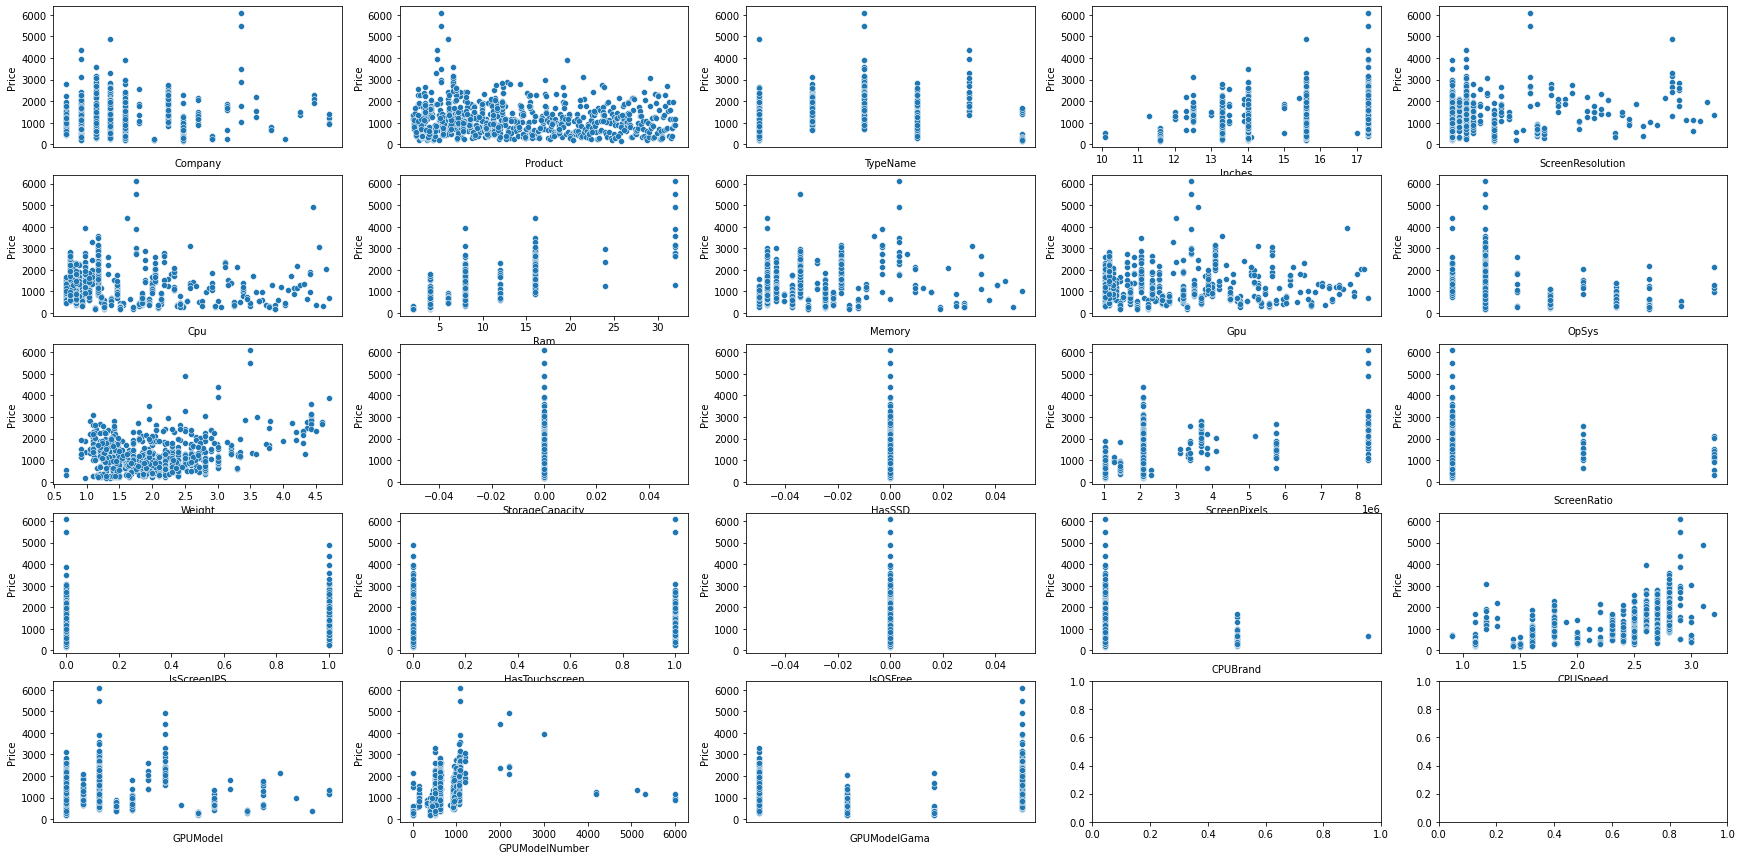

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Relplot
# Scatterplot
# Density plot
# Characteristic line plot

class Draw:
  def __init__(self, model):
    self.model = model
    self.labels = [
        "Company", "Product", "TypeName", "Inches", "ScreenResolution", "Cpu", "Ram", "Memory", "Gpu", "OpSys", "Weight",
        "StorageCapacity", "HasSSD",
        "ScreenPixels", "ScreenRatio", "IsScreenIPS", "HasTouchscreen", "IsOSFree", "CPUBrand", "CPUSpeed", "GPUModel",
        "GPUModelNumber", "GPUModelGama"
    ]

  def get_grid(self, cols, rows, h, w):
      return plt.subplots(rows, cols, figsize=(w, h))

  def histogram(self, labels):
    fig0, axs0 = plt.subplots(ncols=4)
    fig0.set_figwidth(30)
    fig0.set_figheight(5)

    for i, label in enumerate(labels):
      aux = sns.histplot(self.model.X[label], ax=axs0[i])

      aux.set_xticklabels(aux.get_xticklabels(), rotation = 80, horizontalalignment = 'right')

    #plt.show()

  def countplot(self, labels):
    fig0, axs0 = plt.subplots(ncols=4)
    fig0.set_figwidth(30)
    fig0.set_figheight(5)

    for i, label in enumerate(labels):
      aux = sns.countplot(self.model.X[label], ax=axs0[i])

      #aux0.set_xticklabels(aux0.get_xticklabels(), rotation = 85, horizontalalignment = 'right')

      aux.set(xticklabels=label)
      aux.set(xlabel=None)

  def kde(self, labels):
    # El numero de caracteristicas que tienen tipo numerico, para decidir las dimensiones
    n_of_numerical_features = len([ True for f in self.model.X if type(self.model.X[f][0]) != str ])
    
    fig, axs = self.get_grid(rows=n_of_numerical_features//4, cols=4, h=10, w=25)
    fig.delaxes(axs[1][2]) # Elimnar plots vacios
    fig.delaxes(axs[1][3])
    
    i = 0
    for label in labels:
      if type(self.model.X[label][0]) != str:
        sns.kdeplot(self.model.X[label], ax=axs[i//4, i%4])
        i += 1
  
  def relplot(self, labels, hue=None):
    rows, cols = 5, 5
    fig, axs = self.get_grid(rows=rows, cols=cols, h=15, w=30)
    #fig.delaxes(axs[2][3]) # Elimnar plots vacios

    for i, label in enumerate(labels):
      s = sns.scatterplot(data=self.model.X, x=label, y="Price", ax=axs[i//rows, i%rows], hue=hue)

      # Si es una feature con strings, quitar los ticks porque si no no se ve nada
      if type(self.model.X[label][0]) == str:
        s.set(xticklabels=[])  
        s.tick_params(bottom=False)

  def run(self):
    #self.countplot(["ScreenResolution", "Cpu", "Gpu", "Weight"])
    #self.histogram(["ScreenResolution", "Cpu", "Gpu", "Weight"])
    #self.kde(self.labels)
    self.relplot(self.labels)

    #plt.show()

  
draw = Draw(model)
draw.run()